### Import libraries

In [1]:
import random
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import itertools
import numpy as np
import matplotlib.pyplot as plt

### Process the document

In [2]:
file_path = "Fortune.txt"


try:
    with open(file_path, "r") as f:
        contents = f.read()
        # remove numbers, punctuation and special characters using regular expressions
        cleaned_contents = re.sub(r'[^\w\s]|[\d]', '', contents)

        # remove extra whitespace characters
        cleaned_contents = re.sub(r'\s+', ' ', cleaned_contents).strip()
        
except FileNotFoundError:
    print(f"Error: the file {file_path} does not exist")
except Exception as e:
    print(f"Error: an unexpected error occured - {e}")

In [3]:
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

# split contents_cleaned into words
words = cleaned_contents.lower().split()

# filter out stop words
filtered_words = [word for word in words if word not in stop_words]

# join the filtered words back into a string
filtered_contents = " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# save filtered_contents for later use
filtered_contents_path = "Fortune_clean.txt"

with open(filtered_contents_path, 'w') as f:
    f.write(filtered_contents)

In [4]:
# count frequency of each token
unique_values, value_counts = np.unique(filtered_words, return_counts=True)

# create a sorting index based on the value_counts in descending order
sorting_index = np.argsort(-value_counts)

# sort frequency with descending order
sorted_unique_values = unique_values[sorting_index]
sorted_value_counts = value_counts[sorting_index]

tokens_count_df = pd.DataFrame(
    {"token": sorted_unique_values, "count": sorted_value_counts}
)
tokens_count_df

,token,count
0,said,641
1,upon,459
2,sir,434
3,count,330
4,one,328
...,...,...
8298,poise,1
8299,poison,1
8300,poisoned,1
8301,polestar,1


### CountMeanSketch

In [5]:
class CountMeanSketch:
    def __init__(self, epsilon, delta):
        self.epsilon = epsilon
        self.delta = delta

        self.w = math.ceil(math.exp(1) / epsilon)
        self.d = math.ceil(math.log(1 / delta))

        # print("------------------------------")
        # print("initialize CountMeanSketch")
        # print(f"width: {self.w}")
        # print(f"#hash function: {self.d}")
        # print("------------------------------")

        # init the sketch with zero values
        self.matrix = [[0] * self.w for _ in range(self.d)]

        self.p = 122354367
        self.a = random.randrange(self.p)
        self.b = random.randrange(self.p)

    def h(self, x):
        return ((self.a * hash(x) + self.b) % self.p) % self.w

    def update(self, x, c_t):
        # update matrix: add c_t to item x
        for i in range(self.d):
            hash_value = self.h(x)
            self.matrix[i][hash_value] += c_t

    def estimate(self, x):
        min_count = float("inf")
        for i in range(self.d):
            hash_value = self.h(x)
            min_count = min(min_count, self.matrix[i][hash_value])

        return min_count

### Find an optimal pair of `epsilon` and `delta`

In [6]:
estimated_counts = dict()
epsilon_values = [0.001, 0.0001, 0.00001]
delta_values = [0.001, 0.0001, 0.00001]
history = {"epsilon": [], "delta": [], "mean_mae": [], "std_mae": []}

# I test with multiple pairs of epsilon and delta to evaluate the result
# metrics: mean absolute error MAE
for epsilon, delta in itertools.product(epsilon_values, delta_values):
    # for each pair of epsilon and delta, I bootstrap 50 times to calculate the mean and standard error of MAE
    mae = []
    for _ in range(50):
        cm_sketch = CountMeanSketch(epsilon, delta)

        for item in filtered_words:
            cm_sketch.update(item, 1)

        counts = [
            cm_sketch.estimate(token) for token in tokens_count_df["token"]
        ]

        mae.append(
            np.sum(
                [np.abs(a - b) for a, b in zip(counts, tokens_count_df["count"])]
            )
            / len(counts)
        )
        del cm_sketch

    history["epsilon"].append(epsilon)
    history["delta"].append(delta)
    history["mean_mae"].append(np.mean(mae))
    history["std_mae"].append(np.std(mae))

In [21]:
pd.DataFrame(history)

,epsilon,delta,mean_mae,std_mae
0,0.00100,0.00100,17.006277,0.362467
1,0.00100,0.00010,17.065752,0.372086
2,0.00100,0.00001,17.145164,0.387825
3,0.00010,0.00100,2.568346,1.523782
4,0.00010,0.00010,2.706629,1.535514
5,0.00010,0.00001,2.678579,1.582534
6,0.00001,0.00100,0.177859,0.036337
7,0.00001,0.00010,0.169161,0.032179
8,0.00001,0.00001,0.165326,0.031147


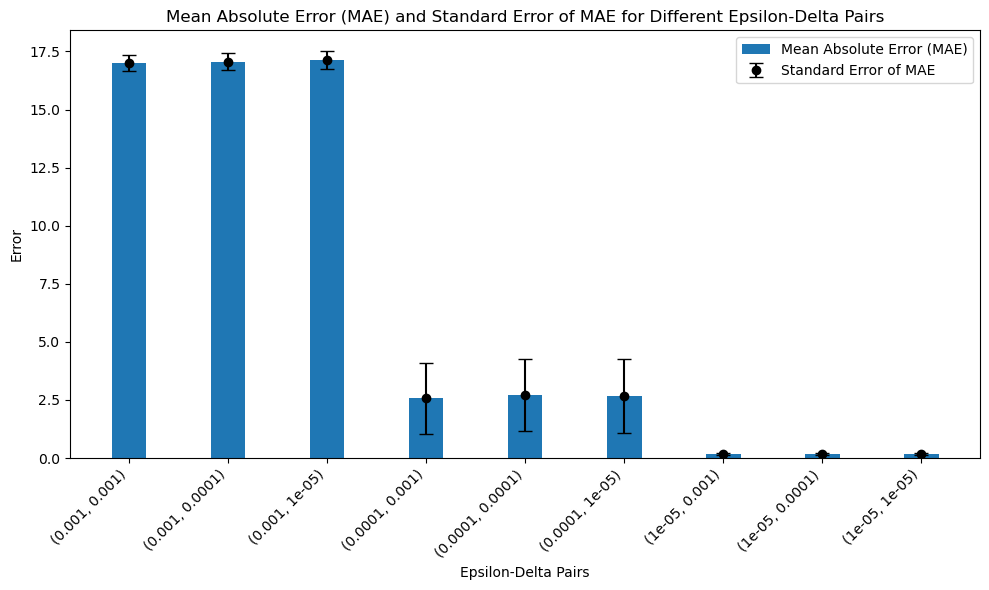

In [22]:
epsilon = history['epsilon']
delta = history['delta']
mean_mae = history['mean_mae']
std_mae = history['std_mae']

plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(range(len(epsilon)), mean_mae, bar_width, label='Mean Absolute Error (MAE)')
plt.errorbar(range(len(epsilon)), mean_mae, yerr=std_mae, fmt='o', capsize=5, label='Standard Error of MAE', color='black')

plt.xticks(range(len(epsilon)), [f'({eps}, {del_})' for eps, del_ in zip(epsilon, delta)], rotation=45, ha='right')
plt.xlabel('Epsilon-Delta Pairs')
plt.ylabel('Error')
plt.title('Mean Absolute Error (MAE) and Standard Error of MAE for Different Epsilon-Delta Pairs')
plt.legend()

plt.tight_layout()
plt.show()

### Example with 10 most frequent tokens

In [33]:
cm_sketch = CountMeanSketch(epsilon=0.001, delta=0.001)

for item in filtered_words:
    cm_sketch.update(item, 1)

# estimate counts
# I choose top 10 words with highest count
random_words = tokens_count_df.head(20)["token"]
estimations = {"word": [], "estimated count": [], "count": []}

for random_word in random_words:
    estimations["word"].append(random_word)
    estimations["estimated count"].append(cm_sketch.estimate(random_word))
    # print(f"{random_word}: {cm_sketch.estimate(random_word)}")

estimations['count'] = tokens_count_df.head(20)['count']
estimation_df = pd.DataFrame(estimations)
estimation_df

,word,estimated count,count
0,said,667,641
1,upon,459,459
2,sir,440,434
3,count,352,330
4,one,343,328
5,richard,328,314
6,would,439,302
7,good,309,302
8,yet,290,285
9,nullepart,283,283


If we choose `epsilon=0.001` and `delta=0.001`, there are some error in the estimation.
Based on the experiment with multiple pairs of `epsilon` and `delta`, we can choose the pair `(0.00001, 0.001)` that produces very small MAE.

In [34]:
cm_sketch = CountMeanSketch(epsilon=0.00001, delta=0.001)

for item in filtered_words:
    cm_sketch.update(item, 1)

# estimate counts
# I choose top 20 words with highest count
random_words = tokens_count_df.head(20)["token"]
estimations = {"word": [], "estimated count": [], "count": []}

for random_word in random_words:
    estimations["word"].append(random_word)
    estimations["estimated count"].append(cm_sketch.estimate(random_word))
    # print(f"{random_word}: {cm_sketch.estimate(random_word)}")

estimations['count'] = tokens_count_df.head(20)['count']
estimation_df = pd.DataFrame(estimations)
estimation_df

,word,estimated count,count
0,said,641,641
1,upon,459,459
2,sir,434,434
3,count,330,330
4,one,328,328
5,richard,314,314
6,would,302,302
7,good,302,302
8,yet,285,285
9,nullepart,283,283


As we can see, there is no difference between the estimated count and the true value of top 10 most frequent tokens. This can be explained because decreasing (epsilon, delta) is equivalent to increasing number of width and hash functions. This is the trade-off between space used and accuracy of CountMinSketch.